In [1]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set input directories

In [2]:
input_dir = os.path.join("raw_data", "rocksdb_data")
filepath_configs = os.path.join(input_dir, "configs.csv")
filepath_external = os.path.join(input_dir, "external_ensamble.csv")

# Read all configurations (N=20000)

In [3]:
target_knobinfo = {
    "max_background_compactions":"int",
    "max_background_flushes":"int",
    "write_buffer_size":"int",
    "max_write_buffer_number":"int",
    "min_write_buffer_number_to_merge":"int",
    "compaction_pri":"category",
    #"compaction_style":"bool", # <- this is not target because the number of unique values is one.
    "level0_file_num_compaction_trigger":"int",
    "level0_slowdown_writes_trigger":"int",
    "level0_stop_writes_trigger":"int",
    "compression_type":"category",
    "bloom_locality":"bool",
    "open_files":"category",
    "block_size":"int",
    "cache_index_and_filter_blocks":"bool",
    "max_bytes_for_level_base":"int",
    "max_bytes_for_level_multiplier":"int",
    "target_file_size_base":"int",
    "target_file_size_multiplier":"int",
    "num_levels":"int",
    "memtable_bloom_size_ratio":"float",
    "compression_ratio":"float"
}

target_knobnames = list(target_knobinfo.keys())

num_configs = 20000

In [4]:
def format_bool(df, colname, table={"yes":1, "no":0}):
    series = df.loc[:,colname]
    df[series.name] = series.map(table)
    return df

def format_int(df, colname):
    series = df.loc[:,colname]
    df[series.name] = series.astype(int)
    return df

def format_float(df, colname):
    series = df.loc[:,colname]
    df[series.name] = series.astype(float)
    return df
    
def format_category(df, colname):
    series = df.loc[:,colname]
    df = df.drop(columns=series.name)
    for val in series.unique():
        newkey = f"{series.name}+{val}"
        df[newkey] = (series == val).astype(int)
    return df

def format_auto(df, colname, dtype, table={"yes":1, "no":0}):
    if dtype == "bool": return format_bool(df, colname, table)
    elif dtype == "int" : return format_int(df, colname)
    elif dtype == "float": return format_float(df, colname)
    elif dtype == "category": return format_category(df, colname)

In [5]:
df_configs = pd.read_csv(filepath_configs)
df_configs = df_configs[target_knobnames]
for colname, dtype in target_knobinfo.items():
    if colname == "bloom_locality":
        df_configs = format_auto(df_configs, colname, dtype, table={1:1, 0:0})
    elif colname == "cache_index_and_filter_blocks":
        df_configs = format_auto(df_configs, colname, dtype, table={True:1, False:0})
    else:
        df_configs = format_auto(df_configs, colname, dtype)

In [6]:
print(df_configs.shape)
df_configs.head()

(20000, 30)


,max_background_compactions,max_background_flushes,write_buffer_size,max_write_buffer_number,min_write_buffer_number_to_merge,level0_file_num_compaction_trigger,level0_slowdown_writes_trigger,level0_stop_writes_trigger,bloom_locality,block_size,...,compaction_pri+2,compaction_pri+3,compression_type+snappy,compression_type+zlib,compression_type+none,compression_type+lz4,open_files+10000,open_files+100000,open_files+1000000,open_files+-1
0,6,16,1304576,3,2,3,24,44,0,9216,...,0,0,1,0,0,0,1,0,0,0
1,2,14,911360,6,2,7,18,55,1,15360,...,0,0,1,0,0,0,0,1,0,0
2,8,6,1474560,6,1,5,18,48,0,6144,...,1,0,0,1,0,0,0,0,1,0
3,12,8,550912,7,1,4,18,35,0,3072,...,0,1,0,1,0,0,1,0,0,0
4,11,15,1426432,5,1,5,23,59,1,5120,...,0,0,0,0,1,0,1,0,0,0


In [7]:
def validity_check(df_configs, num_configs):
    ## numconfigs
    assert len(df_configs) == num_configs
    return True
    
validity_check(df_configs, num_configs)

True

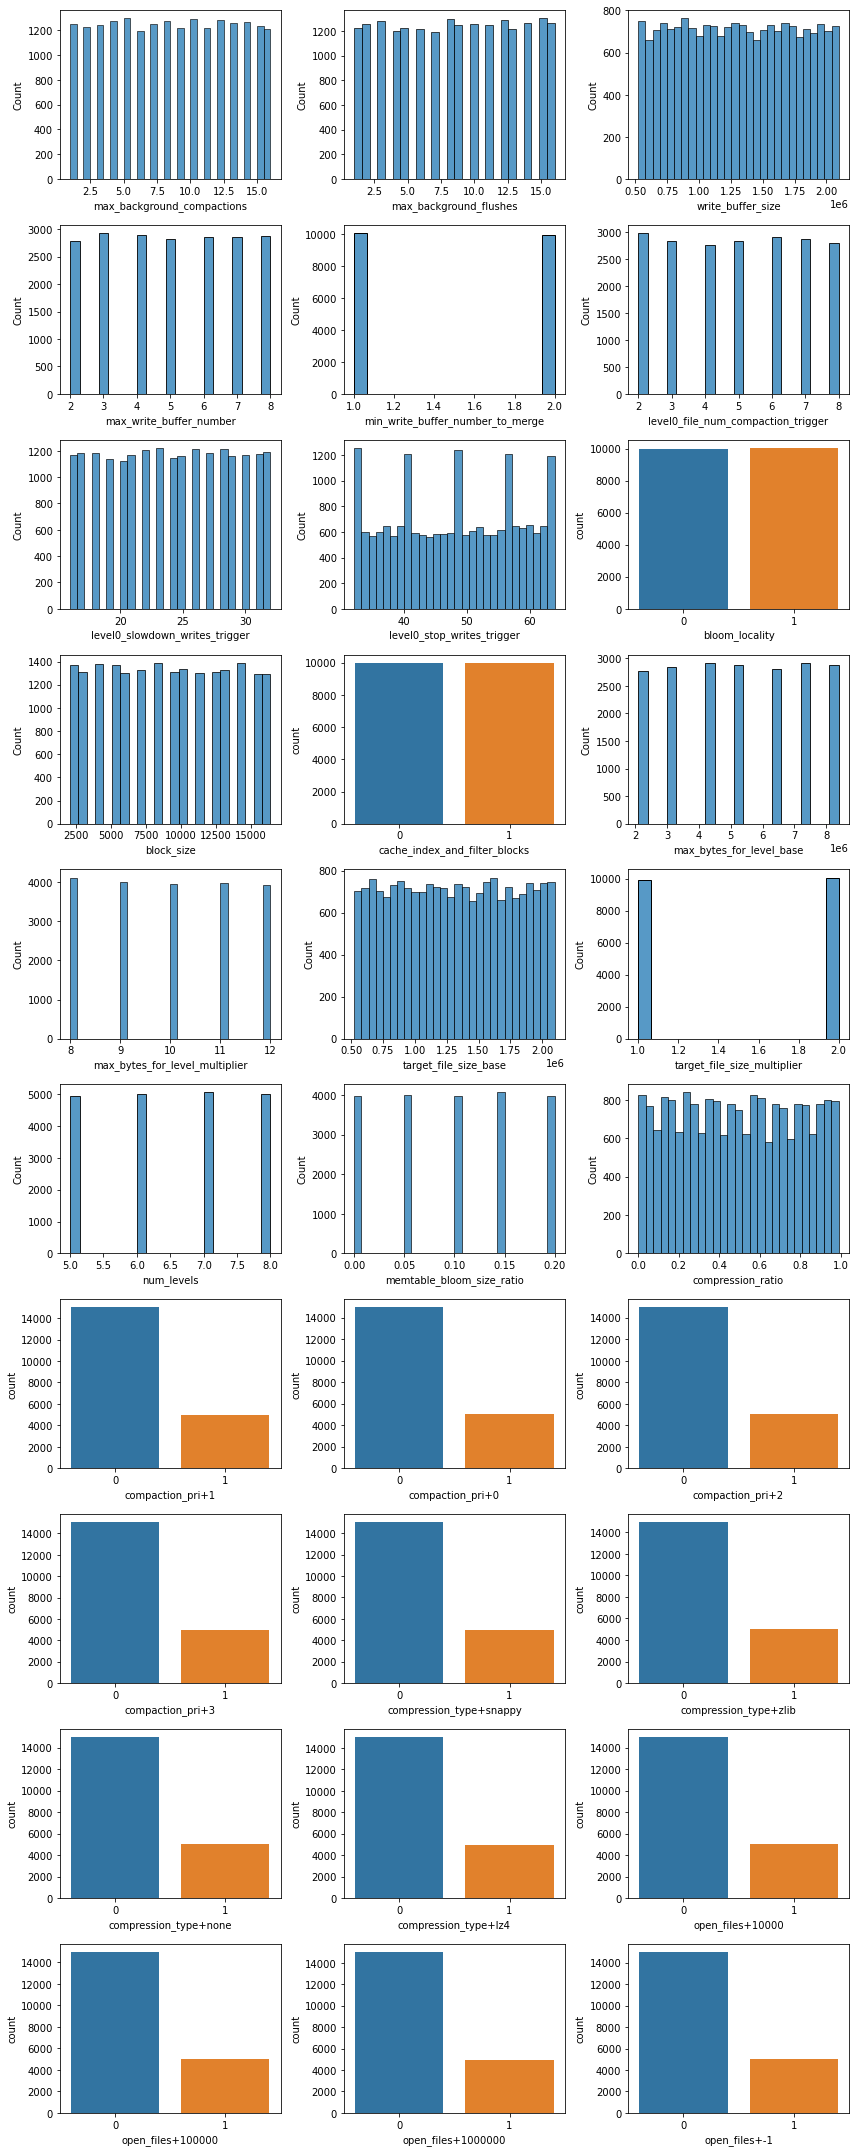

In [8]:
n_cols = 3
n_rows = math.ceil(df_configs.shape[1] / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols,3*n_rows))

for ax, colname in zip(axes.ravel(), df_configs.columns):
    dtype = target_knobinfo[colname.split("+")[0]]
    if dtype == "bool" or dtype == "category":
        sns.countplot(data=df_configs, x=colname, ax=ax)
    else:
        sns.histplot(data=df_configs, x=colname, ax=ax)

plt.tight_layout()
plt.show()

# Read external data

workload information ("Read:Write ratio (value size)" OR "update (value size)")
- 01) 9:1 (1)
- 02) 9:1 (4)
- 03) 9:1 (16)
- 04) 9:1 (64)
- 05) 1:1 (1)
- 06) 1:1 (4)
- 07) 1:1 (16)
- 08) 1:1 (64)
- 09) 1:9 (1)
- 10) 1:9 (4)
- 11) 1:9 (16)
- 12) 1:9 (64)
- 13) update (1)
- 14) update (4)
- 15) update (16)
- 16) update (64)

common specs
- size of requests: 1.0 GB
- key size: 16 Bytes

In [9]:
target_externalnames = [
    "TIME",
    "RATE",
    "WAF",
    "SA"
]

num_workloads = 16

In [10]:
def read_external(filepath, target_externalnames, num_configs, num_workloads):
    ## Read a file
    df = pd.read_csv(filepath)
    df = df.loc[:,target_externalnames]
    ## Split into workloads
    frames = []
    for i in range(num_workloads):
        frames.append(df.iloc[i*num_configs:(i+1)*num_configs,:].reset_index(drop=True))
    return frames

In [11]:
frames = read_external(filepath_external, target_externalnames, num_configs, num_workloads)

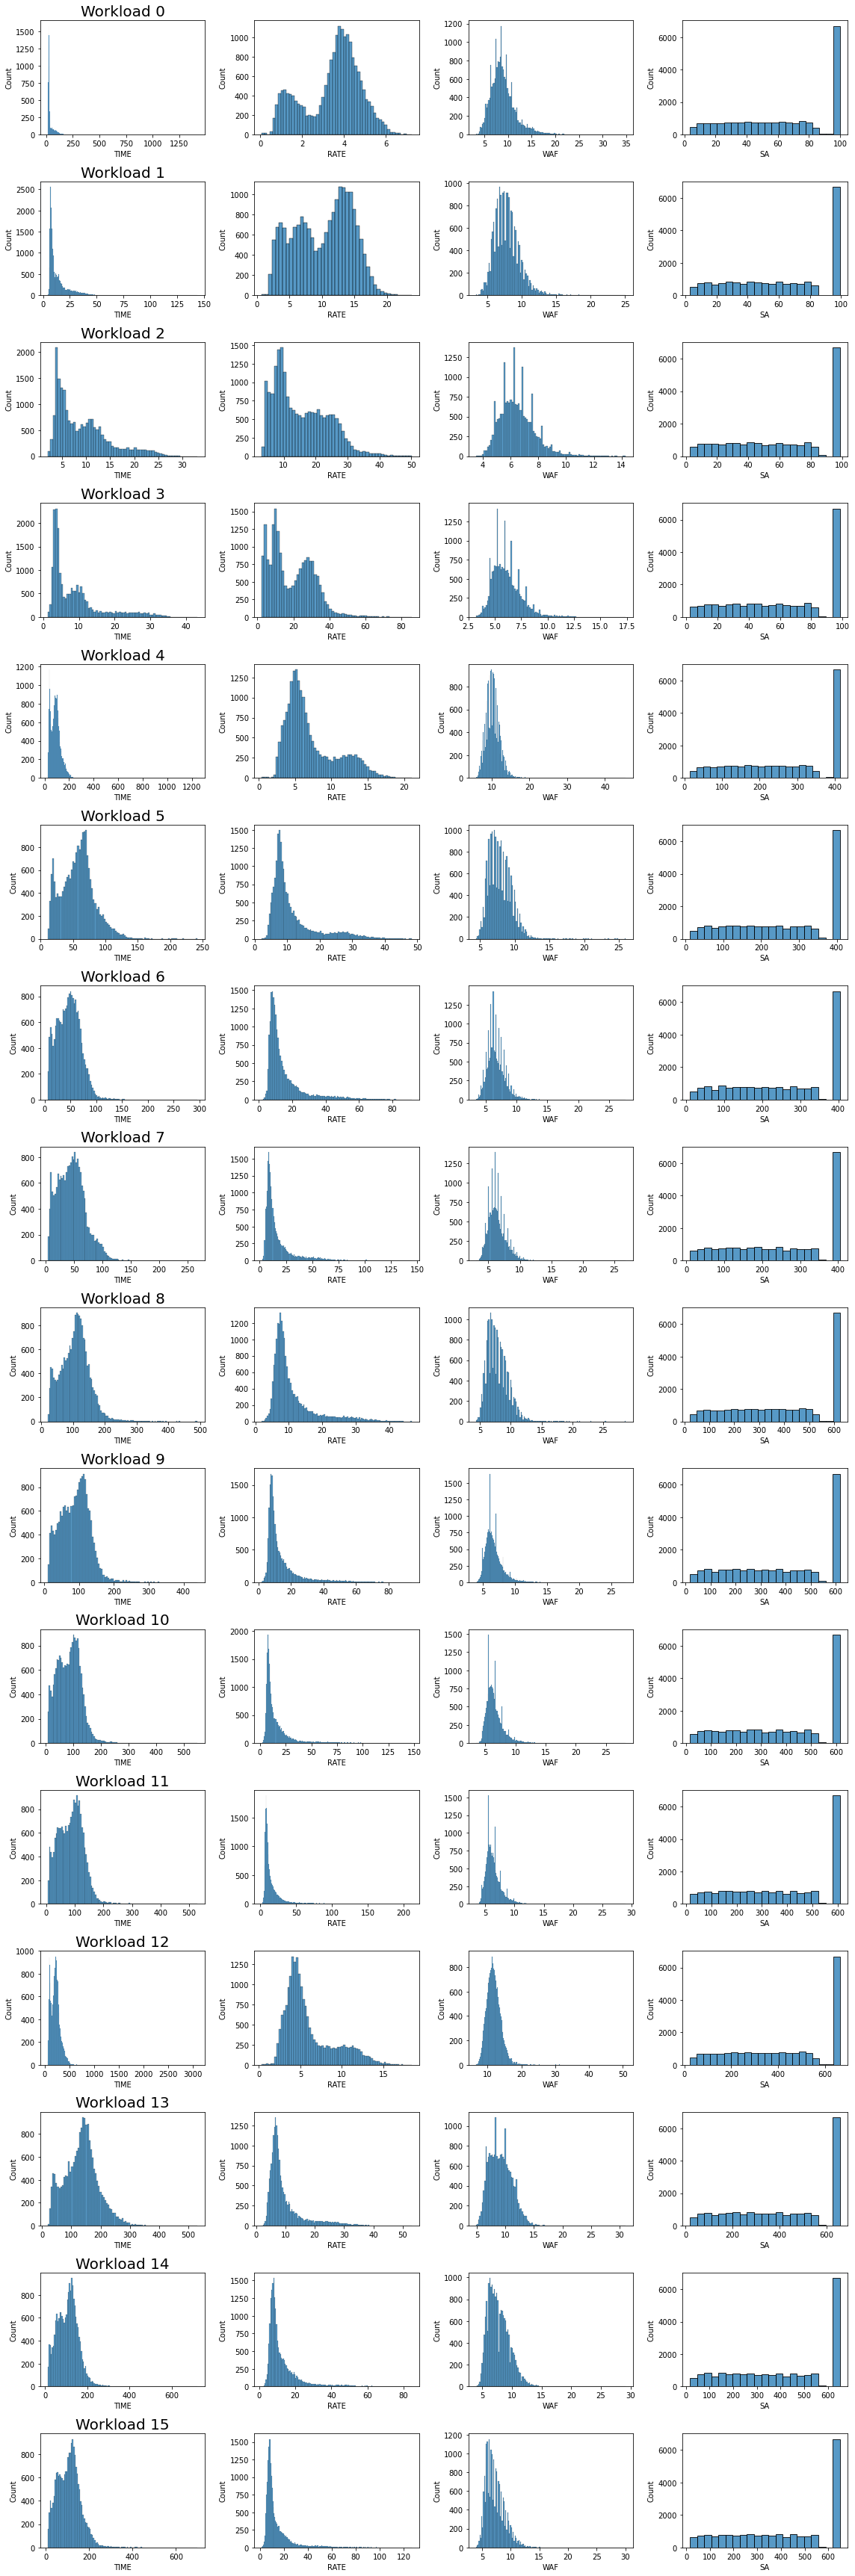

In [12]:
n_cols = len(target_externalnames)
n_rows = num_workloads

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols,3*n_rows))

for i, (ax, df_external) in enumerate(zip(axes, frames)):
    ax[0].set_title(f"Workload {i}", fontsize=20)
    for j, colname in enumerate(target_externalnames):
        sns.histplot(data=df_external, x=colname, ax=ax[j])

plt.tight_layout()
plt.show()

# Merge and Save

In [13]:
for i, df_external in enumerate(frames):
    df_merge = df_external.merge(df_configs, left_index=True, right_index=True)
    filename = f"rocksdb_benchmark_{i}.csv"
    df_merge.to_csv(filename, index=False)